# Support Vector Machines

Let's stick with our example of classifying vehicle speeds based on the size of a bump, and our distance to it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

C:\Users\cheth\AppData\Local\Temp/ipykernel_10796/2279399494.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


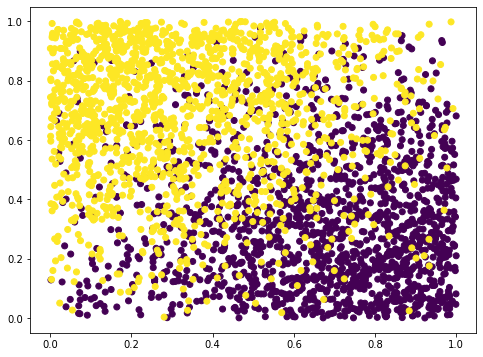

In [2]:
%matplotlib inline
from pylab import *

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
plt.show()

Now we'll use linear SVC to partition our graph into clusters:

In [3]:
from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=1.0).fit(X, y)

By setting up a dense mesh of points in the grid and classifying all of them, we can render the regions of each cluster as distinct colors:

C:\Users\cheth\AppData\Local\Temp/ipykernel_10796/1569627025.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


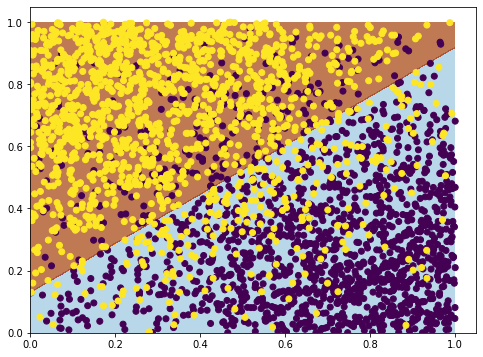

In [4]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.show()
    
plotPredictions(svc)

Or just use predict for a given point:

In [5]:
print(svc.predict([[0.3, 0.3]]))

[0]


In [6]:
print(svc.predict([[0, 1]]))

[1]


In [7]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(svc, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.86721311 0.83934426 0.8407225  0.83087028 0.83415435]
0.8424609006971924


## Hyperparameter tuning and RBF

We warned the the RBF kernel, although very powerful, is prone to over-fitting if gamma is set too high. Let's explore whether RBF is an appropriate kernel for our simple data set, and if so, what sort of gamma value makes sense.

Let's start by assuming RBF can handle this without breaking a sweat, and just try and find the best gamma value. We'll use GridSearchCV, which is an easy way of doing k-fold cross validation over an array of different parameter values we want to try out. We call this process "hyperparameter tuning."

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

param_grid = dict(gamma=[0, 0.5, 1.0, 2.0, 3.0, 10.0, 100.0, 1000.0])
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=10)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'gamma': 0.5} with a score of 0.84


Hm, so we ended up with a very low gamma value working out best. What does it look like?

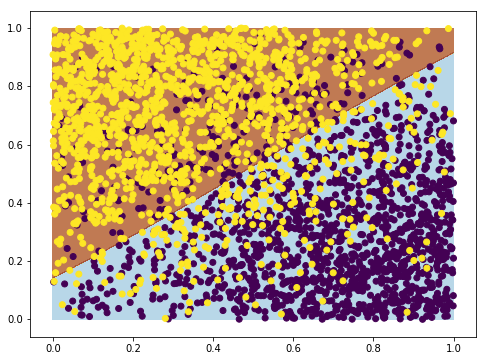

In [9]:
svc = svm.SVC(kernel='rbf', gamma=grid.best_params_['gamma']).fit(X, y)

plotPredictions(svc)

Well, that looks really close to a linear kernel. So, maybe RBF is overkill for this data set. Let's assume linear is the way to go, and just try to tune its hyperparameter of "C":

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

param_grid = dict(C=[0.1, 0.5, 1.0, 2.0, 3.0, 10.0, 100.0, 1000.0])
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, cv=10)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.5} with a score of 0.84


A low value of C works best, it seems. Let's see how it looks:

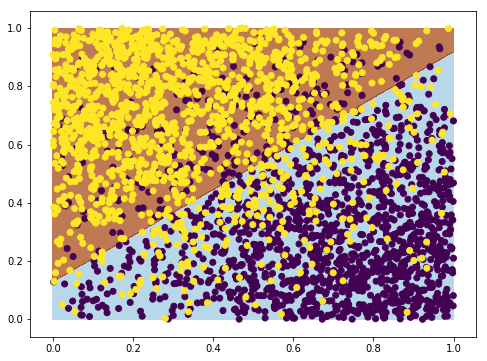

In [11]:
svc = svm.SVC(kernel='linear', C=grid.best_params_['C']).fit(X, y)

plotPredictions(svc)

Looks pretty much identical to the rbf kernel with a small gamma, but the model is much simpler - and given the choice between simple and complex, simple is always the right choice all things being equal.